In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [60]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/daily-total-female-births.csv')
df['Date']= pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#df.index.freq='MS'

In [61]:
df = df[-120:]
df.head()

,Births
Date,
1959-09-03,40
1959-09-04,42
1959-09-05,51
1959-09-06,44
1959-09-07,45


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1959-09-03 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  120 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


<AxesSubplot:xlabel='Date'>

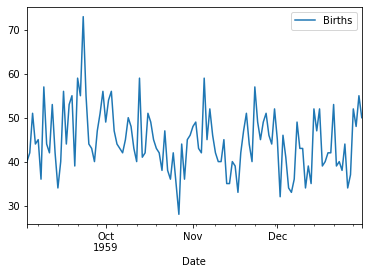

In [63]:
df.plot()

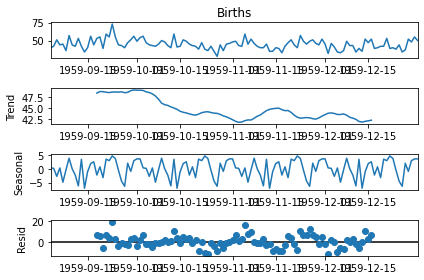

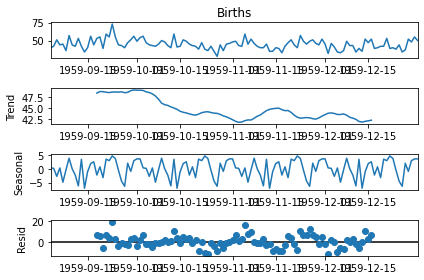

In [64]:
results = seasonal_decompose(df['Births'], freq=30)
results.plot()

In [65]:
len(df)

120

In [66]:
train = df.iloc[:90]
test = df.iloc[90:]

scaler = MinMaxScaler()

In [67]:
df.head(), df.tail()

(            Births
 Date              
 1959-09-03      40
 1959-09-04      42
 1959-09-05      51
 1959-09-06      44
 1959-09-07      45,
             Births
 Date              
 1959-12-27      37
 1959-12-28      52
 1959-12-29      48
 1959-12-30      55
 1959-12-31      50)

In [68]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.26666667],
       [0.31111111],
       [0.51111111],
       [0.35555556],
       [0.37777778],
       [0.17777778],
       [0.64444444],
       [0.35555556],
       [0.31111111],
       [0.55555556]])

# Recursive Strategy

In [69]:
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.26666667],
         [0.31111111],
         [0.51111111],
         [0.35555556],
         [0.37777778],
         [0.17777778],
         [0.64444444],
         [0.35555556],
         [0.31111111],
         [0.55555556],
         [0.31111111],
         [0.13333333],
         [0.26666667],
         [0.62222222],
         [0.35555556],
         [0.55555556],
         [0.6       ],
         [0.24444444],
         [0.68888889],
         [0.6       ],
         [1.        ],
         [0.6       ],
         [0.35555556],
         [0.33333333],
         [0.26666667],
         [0.42222222],
         [0.51111111],
         [0.62222222],
         [0.46666667],
         [0.57777778]]]),
 array([[0.62222222]]))

In [70]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_153 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(generator, epochs=50, verbose=0)

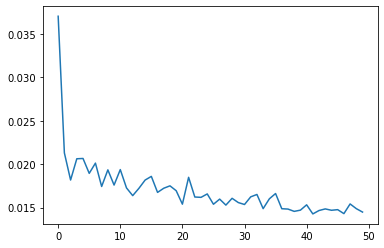

In [72]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [73]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.39800775]], dtype=float32)

In [74]:
scaled_test[0], scaled_test[1]

(array([0.08888889]), array([0.4]))

In [75]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.39800775], dtype=float32),
 array([0.37988073], dtype=float32),
 array([0.3608333], dtype=float32),
 array([0.34110212], dtype=float32),
 array([0.32322377], dtype=float32),
 array([0.31195962], dtype=float32),
 array([0.31302476], dtype=float32),
 array([0.32748866], dtype=float32),
 array([0.35228193], dtype=float32),
 array([0.37794095], dtype=float32),
 array([0.40172458], dtype=float32),
 array([0.42189574], dtype=float32),
 array([0.43546015], dtype=float32),
 array([0.44406402], dtype=float32),
 array([0.44966936], dtype=float32),
 array([0.44956887], dtype=float32),
 array([0.44467324], dtype=float32),
 array([0.43969303], dtype=float32),
 array([0.43404633], dtype=float32),
 array([0.42645985], dtype=float32),
 array([0.41616887], dtype=float32),
 array([0.40273273], dtype=float32),
 array([0.38778472], dtype=float32),
 array([0.37095338], dtype=float32),
 array([0.35265028], dtype=float32),
 array([0.33478576], dtype=float32),
 array([0.32017013], dtype=float32),
 a

In [76]:
test.head()

,Births
Date,
1959-12-02,32
1959-12-03,46
1959-12-04,41
1959-12-05,34
1959-12-06,33


In [77]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Date'>

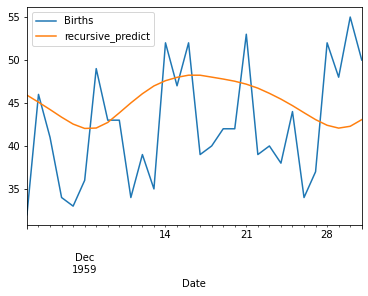

In [78]:
test.plot()

In [79]:
rmse = sqrt(mean_squared_error(test['Births'], test['recursive_predict']))
print(rmse)

7.503746236010255


In [80]:
test

,Births,recursive_predict
Date,,
1959-12-02,32,45.910349
1959-12-03,46,45.094633
1959-12-04,41,44.237498
1959-12-05,34,43.349596
1959-12-06,33,42.545070
1959-12-07,36,42.038183
1959-12-08,49,42.086114
1959-12-09,43,42.736990
1959-12-10,43,43.852687


# Direct Startegy

In [81]:
def generate_data(data, n_input, date):
    X, y = [], []
    for i in range(0,len(data)-(n_input+date)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(date-1)])
    return np.array(X), np.array(y)

In [82]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    print("MODEL : ", m_no)
    print(X, y)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [83]:
len(scaled_test)

30

In [84]:
n_input = 30
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

MODEL :  1
[[[0.26666667]
  [0.31111111]
  [0.51111111]
  ...
  [0.62222222]
  [0.46666667]
  [0.57777778]]

 [[0.31111111]
  [0.51111111]
  [0.35555556]
  ...
  [0.46666667]
  [0.57777778]
  [0.62222222]]

 [[0.51111111]
  [0.35555556]
  [0.37777778]
  ...
  [0.57777778]
  [0.62222222]
  [0.42222222]]

 ...

 [[0.17777778]
  [0.37777778]
  [0.4       ]
  ...
  [0.37777778]
  [0.46666667]
  [0.51111111]]

 [[0.37777778]
  [0.4       ]
  [0.44444444]
  ...
  [0.46666667]
  [0.51111111]
  [0.4       ]]

 [[0.4       ]
  [0.44444444]
  [0.46666667]
  ...
  [0.51111111]
  [0.4       ]
  [0.35555556]]] [[0.62222222]
 [0.42222222]
 [0.35555556]
 [0.33333333]
 [0.31111111]
 [0.37777778]
 [0.48888889]
 [0.44444444]
 [0.33333333]
 [0.26666667]
 [0.68888889]
 [0.28888889]
 [0.31111111]
 [0.51111111]
 [0.46666667]
 [0.37777778]
 [0.33333333]
 [0.31111111]
 [0.22222222]
 [0.42222222]
 [0.22222222]
 [0.17777778]
 [0.31111111]
 [0.15555556]
 [0.        ]
 [0.35555556]
 [0.17777778]
 [0.37777778]
 [0

MODEL :  7
[[[0.26666667]
  [0.31111111]
  [0.51111111]
  ...
  [0.62222222]
  [0.46666667]
  [0.57777778]]

 [[0.31111111]
  [0.51111111]
  [0.35555556]
  ...
  [0.46666667]
  [0.57777778]
  [0.62222222]]

 [[0.51111111]
  [0.35555556]
  [0.37777778]
  ...
  [0.57777778]
  [0.62222222]
  [0.42222222]]

 ...

 [[0.22222222]
  [0.17777778]
  [0.31111111]
  ...
  [0.42222222]
  [0.51111111]
  [0.35555556]]

 [[0.17777778]
  [0.31111111]
  [0.15555556]
  ...
  [0.51111111]
  [0.35555556]
  [0.26666667]]

 [[0.31111111]
  [0.15555556]
  [0.        ]
  ...
  [0.35555556]
  [0.26666667]
  [0.64444444]]] [[0.48888889]
 [0.44444444]
 [0.33333333]
 [0.26666667]
 [0.68888889]
 [0.28888889]
 [0.31111111]
 [0.51111111]
 [0.46666667]
 [0.37777778]
 [0.33333333]
 [0.31111111]
 [0.22222222]
 [0.42222222]
 [0.22222222]
 [0.17777778]
 [0.31111111]
 [0.15555556]
 [0.        ]
 [0.35555556]
 [0.17777778]
 [0.37777778]
 [0.4       ]
 [0.44444444]
 [0.46666667]
 [0.33333333]
 [0.31111111]
 [0.68888889]
 [0

MODEL :  14
[[[0.26666667]
  [0.31111111]
  [0.51111111]
  ...
  [0.62222222]
  [0.46666667]
  [0.57777778]]

 [[0.31111111]
  [0.51111111]
  [0.35555556]
  ...
  [0.46666667]
  [0.57777778]
  [0.62222222]]

 [[0.51111111]
  [0.35555556]
  [0.37777778]
  ...
  [0.57777778]
  [0.62222222]
  [0.42222222]]

 ...

 [[0.51111111]
  [0.46666667]
  [0.37777778]
  ...
  [0.37777778]
  [0.15555556]
  [0.15555556]]

 [[0.46666667]
  [0.37777778]
  [0.33333333]
  ...
  [0.15555556]
  [0.15555556]
  [0.26666667]]

 [[0.37777778]
  [0.33333333]
  [0.31111111]
  ...
  [0.15555556]
  [0.26666667]
  [0.24444444]]] [[0.51111111]
 [0.46666667]
 [0.37777778]
 [0.33333333]
 [0.31111111]
 [0.22222222]
 [0.42222222]
 [0.22222222]
 [0.17777778]
 [0.31111111]
 [0.15555556]
 [0.        ]
 [0.35555556]
 [0.17777778]
 [0.37777778]
 [0.4       ]
 [0.44444444]
 [0.46666667]
 [0.33333333]
 [0.31111111]
 [0.68888889]
 [0.37777778]
 [0.53333333]
 [0.4       ]
 [0.31111111]
 [0.26666667]
 [0.26666667]
 [0.37777778]
 [

MODEL :  21
[[[0.26666667]
  [0.31111111]
  [0.51111111]
  ...
  [0.62222222]
  [0.46666667]
  [0.57777778]]

 [[0.31111111]
  [0.51111111]
  [0.35555556]
  ...
  [0.46666667]
  [0.57777778]
  [0.62222222]]

 [[0.51111111]
  [0.35555556]
  [0.37777778]
  ...
  [0.57777778]
  [0.62222222]
  [0.42222222]]

 ...

 [[0.48888889]
  [0.44444444]
  [0.33333333]
  ...
  [0.68888889]
  [0.37777778]
  [0.53333333]]

 [[0.44444444]
  [0.33333333]
  [0.26666667]
  ...
  [0.37777778]
  [0.53333333]
  [0.4       ]]

 [[0.33333333]
  [0.26666667]
  [0.68888889]
  ...
  [0.53333333]
  [0.4       ]
  [0.31111111]]] [[0.22222222]
 [0.17777778]
 [0.31111111]
 [0.15555556]
 [0.        ]
 [0.35555556]
 [0.17777778]
 [0.37777778]
 [0.4       ]
 [0.44444444]
 [0.46666667]
 [0.33333333]
 [0.31111111]
 [0.68888889]
 [0.37777778]
 [0.53333333]
 [0.4       ]
 [0.31111111]
 [0.26666667]
 [0.26666667]
 [0.37777778]
 [0.15555556]
 [0.15555556]
 [0.26666667]
 [0.24444444]
 [0.11111111]
 [0.31111111]
 [0.42222222]
 [

MODEL :  28
[[[0.26666667]
  [0.31111111]
  [0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.35555556]
  [0.31111111]
  [0.55555556]
  [0.31111111]
  [0.13333333]
  [0.26666667]
  [0.62222222]
  [0.35555556]
  [0.55555556]
  [0.6       ]
  [0.24444444]
  [0.68888889]
  [0.6       ]
  [1.        ]
  [0.6       ]
  [0.35555556]
  [0.33333333]
  [0.26666667]
  [0.42222222]
  [0.51111111]
  [0.62222222]
  [0.46666667]
  [0.57777778]]

 [[0.31111111]
  [0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.35555556]
  [0.31111111]
  [0.55555556]
  [0.31111111]
  [0.13333333]
  [0.26666667]
  [0.62222222]
  [0.35555556]
  [0.55555556]
  [0.6       ]
  [0.24444444]
  [0.68888889]
  [0.6       ]
  [1.        ]
  [0.6       ]
  [0.35555556]
  [0.33333333]
  [0.26666667]
  [0.42222222]
  [0.51111111]
  [0.62222222]
  [0.46666667]
  [0.57777778]
  [0.62222222]]

 [[0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.3555

MODEL :  29
[[[0.26666667]
  [0.31111111]
  [0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.35555556]
  [0.31111111]
  [0.55555556]
  [0.31111111]
  [0.13333333]
  [0.26666667]
  [0.62222222]
  [0.35555556]
  [0.55555556]
  [0.6       ]
  [0.24444444]
  [0.68888889]
  [0.6       ]
  [1.        ]
  [0.6       ]
  [0.35555556]
  [0.33333333]
  [0.26666667]
  [0.42222222]
  [0.51111111]
  [0.62222222]
  [0.46666667]
  [0.57777778]]

 [[0.31111111]
  [0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.35555556]
  [0.31111111]
  [0.55555556]
  [0.31111111]
  [0.13333333]
  [0.26666667]
  [0.62222222]
  [0.35555556]
  [0.55555556]
  [0.6       ]
  [0.24444444]
  [0.68888889]
  [0.6       ]
  [1.        ]
  [0.6       ]
  [0.35555556]
  [0.33333333]
  [0.26666667]
  [0.42222222]
  [0.51111111]
  [0.62222222]
  [0.46666667]
  [0.57777778]
  [0.62222222]]

 [[0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.3555

MODEL :  30
[[[0.26666667]
  [0.31111111]
  [0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.35555556]
  [0.31111111]
  [0.55555556]
  [0.31111111]
  [0.13333333]
  [0.26666667]
  [0.62222222]
  [0.35555556]
  [0.55555556]
  [0.6       ]
  [0.24444444]
  [0.68888889]
  [0.6       ]
  [1.        ]
  [0.6       ]
  [0.35555556]
  [0.33333333]
  [0.26666667]
  [0.42222222]
  [0.51111111]
  [0.62222222]
  [0.46666667]
  [0.57777778]]

 [[0.31111111]
  [0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.35555556]
  [0.31111111]
  [0.55555556]
  [0.31111111]
  [0.13333333]
  [0.26666667]
  [0.62222222]
  [0.35555556]
  [0.55555556]
  [0.6       ]
  [0.24444444]
  [0.68888889]
  [0.6       ]
  [1.        ]
  [0.6       ]
  [0.35555556]
  [0.33333333]
  [0.26666667]
  [0.42222222]
  [0.51111111]
  [0.62222222]
  [0.46666667]
  [0.57777778]
  [0.62222222]]

 [[0.51111111]
  [0.35555556]
  [0.37777778]
  [0.17777778]
  [0.64444444]
  [0.3555

[array([0.38027266], dtype=float32),
 array([0.3670815], dtype=float32),
 array([0.3650596], dtype=float32),
 array([0.364768], dtype=float32),
 array([0.36259145], dtype=float32),
 array([0.3516448], dtype=float32),
 array([0.36923784], dtype=float32),
 array([0.36500832], dtype=float32),
 array([0.353569], dtype=float32),
 array([0.34996483], dtype=float32),
 array([0.3533211], dtype=float32),
 array([0.34483182], dtype=float32),
 array([0.370159], dtype=float32),
 array([0.36720264], dtype=float32),
 array([0.3792449], dtype=float32),
 array([0.36342826], dtype=float32),
 array([0.38564253], dtype=float32),
 array([0.36158776], dtype=float32),
 array([0.36694852], dtype=float32),
 array([0.3450849], dtype=float32),
 array([0.326643], dtype=float32),
 array([0.34916088], dtype=float32),
 array([0.3560356], dtype=float32),
 array([0.36169678], dtype=float32),
 array([0.32993034], dtype=float32),
 array([0.4292203], dtype=float32),
 array([0.37871966], dtype=float32),
 array([0.3794010

In [85]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='Date'>

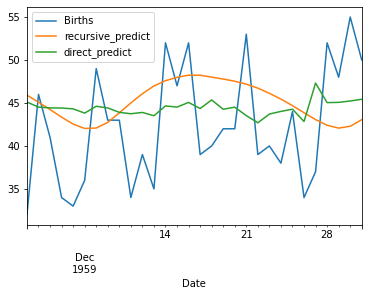

In [86]:
test.plot()

In [87]:
rmse = sqrt(mean_squared_error(test['Births'], test['direct_predict']))
print(rmse)

6.796100642804806


In [88]:
test

,Births,recursive_predict,direct_predict
Date,,,
1959-12-02,32,45.910349,45.112270
1959-12-03,46,45.094633,44.518667
1959-12-04,41,44.237498,44.427683
1959-12-05,34,43.349596,44.414560
1959-12-06,33,42.545070,44.316615
1959-12-07,36,42.038183,43.824017
1959-12-08,49,42.086114,44.615703
1959-12-09,43,42.736990,44.425375
1959-12-10,43,43.852687,43.910605


# Direct Recursive Startegy

In [89]:
def generate_data(data, n_input, date):
    X, y = [], []
    for i in range(0,len(data)-(n_input+date)):
            X.append(data[i:i+n_input+(date-1)])
            y.append(data[i+n_input+(date-1)])
    return np.array(X), np.array(y)

In [90]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [91]:
n_input = 30
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.38539633], dtype=float32),
 array([0.3734437], dtype=float32),
 array([0.36910808], dtype=float32),
 array([0.3729749], dtype=float32),
 array([0.37653977], dtype=float32),
 array([0.37413487], dtype=float32),
 array([0.37427285], dtype=float32),
 array([0.372747], dtype=float32),
 array([0.36620694], dtype=float32),
 array([0.3625751], dtype=float32),
 array([0.3625956], dtype=float32),
 array([0.35236165], dtype=float32),
 array([0.35002905], dtype=float32),
 array([0.36762053], dtype=float32),
 array([0.36597657], dtype=float32),
 array([0.34133616], dtype=float32),
 array([0.33261177], dtype=float32),
 array([0.31546524], dtype=float32),
 array([0.34004486], dtype=float32),
 array([0.38280597], dtype=float32),
 array([0.3317444], dtype=float32),
 array([0.35853517], dtype=float32),
 array([0.34982434], dtype=float32),
 array([0.35763586], dtype=float32),
 array([0.36705005], dtype=float32),
 array([0.3844414], dtype=float32),
 array([0.4117839], dtype=float32),
 array([0.

In [92]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='Date'>

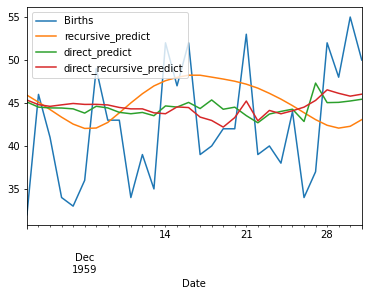

In [93]:
test.plot()

In [94]:
rmse = sqrt(mean_squared_error(test['Births'], test['direct_recursive_predict']))
print(rmse)

6.745297858009195


In [95]:
test

,Births,recursive_predict,direct_predict,direct_recursive_predict
Date,,,,
1959-12-02,32,45.910349,45.112270,45.342835
1959-12-03,46,45.094633,44.518667,44.804966
1959-12-04,41,44.237498,44.427683,44.609864
1959-12-05,34,43.349596,44.414560,44.783871
1959-12-06,33,42.545070,44.316615,44.944290
1959-12-07,36,42.038183,43.824017,44.836069
1959-12-08,49,42.086114,44.615703,44.842278
1959-12-09,43,42.736990,44.425375,44.773615
1959-12-10,43,43.852687,43.910605,44.479312


# MIMO

In [96]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [97]:
n_input = 30
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [98]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [99]:
model.fit(X, y, epochs=50, verbose=0)

In [100]:
model.summary()

Model: "sequential_214"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_214 (LSTM)              (None, 200)               161600    
_________________________________________________________________
dense_214 (Dense)            (None, 30)                6030      
Total params: 167,630
Trainable params: 167,630
Non-trainable params: 0
_________________________________________________________________


In [101]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [102]:
res.shape

(30, 1)

In [103]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [104]:
test

,Births,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
Date,,,,,
1959-12-02,32,45.910349,45.112270,45.342835,43.374882
1959-12-03,46,45.094633,44.518667,44.804966,42.914837
1959-12-04,41,44.237498,44.427683,44.609864,42.166870
1959-12-05,34,43.349596,44.414560,44.783871,42.300884
1959-12-06,33,42.545070,44.316615,44.944290,42.311592
1959-12-07,36,42.038183,43.824017,44.836069,42.632816
1959-12-08,49,42.086114,44.615703,44.842278,41.928692
1959-12-09,43,42.736990,44.425375,44.773615,43.622559
1959-12-10,43,43.852687,43.910605,44.479312,43.244141


<AxesSubplot:xlabel='Date'>

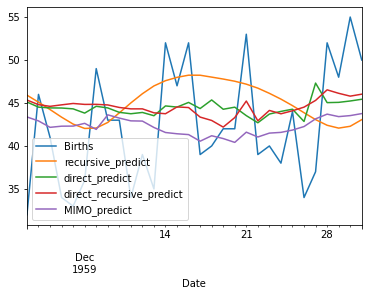

In [105]:
test.plot()

In [106]:
rmse = sqrt(mean_squared_error(test['Births'], test['MIMO_predict']))
print(rmse)

6.627844069887254


# Direct MIMO

In [107]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [108]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [109]:
n_input = 30
n_features = 1
test_predictions = []

n_output = 5

q = int(len(scaled_test)/n_output)


for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.365585  , 0.35292011, 0.35415244, 0.35536295, 0.34995392]],
       dtype=float32),
 array([[0.35906672, 0.3604114 , 0.36318657, 0.35160974, 0.36957884]],
       dtype=float32),
 array([[0.35568458, 0.34284064, 0.34321982, 0.35687378, 0.35592994]],
       dtype=float32),
 array([[0.32807928, 0.30969238, 0.33897072, 0.33442372, 0.31259993]],
       dtype=float32),
 array([[0.3094809 , 0.33421138, 0.3611784 , 0.34821877, 0.3278472 ]],
       dtype=float32),
 array([[0.36107135, 0.3513401 , 0.3690083 , 0.36275864, 0.3640902 ]],
       dtype=float32)]

In [110]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [111]:
res = np.array(res)
res = res.reshape((res.shape[0],1))
res.shape

(30, 1)

In [112]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [113]:
test

,Births,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
Date,,,,,,
1959-12-02,32,45.910349,45.112270,45.342835,43.374882,44.451324
1959-12-03,46,45.094633,44.518667,44.804966,42.914837,43.881405
1959-12-04,41,44.237498,44.427683,44.609864,42.166870,43.936859
1959-12-05,34,43.349596,44.414560,44.783871,42.300884,43.991333
1959-12-06,33,42.545070,44.316615,44.944290,42.311592,43.747925
1959-12-07,36,42.038183,43.824017,44.836069,42.632816,44.158005
1959-12-08,49,42.086114,44.615703,44.842278,41.928692,44.218513
1959-12-09,43,42.736990,44.425375,44.773615,43.622559,44.343395
1959-12-10,43,43.852687,43.910605,44.479312,43.244141,43.822437


<AxesSubplot:xlabel='Date'>

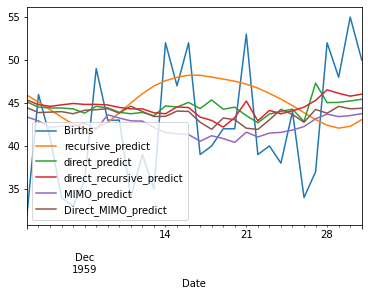

In [114]:
test.plot()

In [115]:
rmse = sqrt(mean_squared_error(test['Births'], test['Direct_MIMO_predict']))
print(rmse)

6.783447270545539


In [116]:
rec_err = abs(test['Births'] - test['recursive_predict'])
dir_err = abs(test['Births'] - test['direct_predict'])
dir_rec_err = abs(test['Births'] - test['direct_recursive_predict'])
mimo_err = abs(test['Births'] - test['MIMO_predict'])
dir_mimo_err = abs(test['Births'] - test['Direct_MIMO_predict'])

In [117]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [118]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
Date,,,,,
1959-12-02,13.910349,13.112270,13.342835,11.374882,12.451324
1959-12-03,0.905367,1.481333,1.195034,3.085163,2.118595
1959-12-04,3.237498,3.427683,3.609864,1.166870,2.936859
1959-12-05,9.349596,10.414560,10.783871,8.300884,9.991333
1959-12-06,9.545070,11.316615,11.944290,9.311592,10.747925
1959-12-07,6.038183,7.824017,8.836069,6.632816,8.158005
1959-12-08,6.913886,4.384297,4.157722,7.071308,4.781487
1959-12-09,0.263010,1.425375,1.773615,0.622559,1.343395
1959-12-10,0.852687,0.910605,1.479312,0.244141,0.822437


<AxesSubplot:xlabel='Date'>

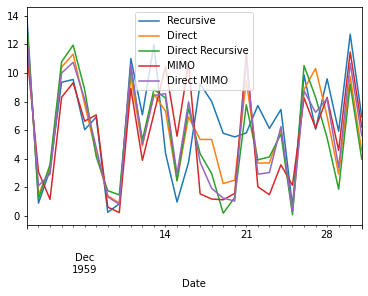

In [119]:
errors.plot()